In [ ]:
#|hide
#|default_exp qcrad

# PyrNet automatic quality checks
In the following, functions for automatic quality screening are developed. Including BSRN recommended physical and rare limits, as well as network sanity checks.

In [2]:
#|export
import xarray as xr
import numpy as np
import warnings
import logging

import pyrnet.data
import pyrnet.utils


# logging setup
logging.basicConfig(
    filename='pyrnet.log',
    encoding='utf-8',
    level=logging.DEBUG,
    format='%(asctime)s %(name)s %(levelname)s:%(message)s'
)
logger = logging.getLogger(__name__)

In [3]:
import matplotlib.pyplot as plt

In [4]:
#|export
class CONSTANTS:
    S0 = 1367  # W m-2
    k = 5.67*1e-8

## BSRN recommended checks
BSRN recommends thresholds for physical and rare limits of GHI data

In [5]:
#|export
class QCCode:
    """ BSRN quality codes
    https://wiki.pangaea.de/wiki/BSRN_Toolbox#Quality_Check
    """
    below_physical = 2**0 # 1
    above_phyiscal = 2**1 # 2
    below_rare = 2**2 # 4
    above_rare = 2**3 # 8
    compare_to_low = 2**4 # 16
    compare_to_high = 2**5 # 32
    quality_control_failed = 2**6 # 64

## Load test dataset:

In [6]:
#|dropcode
#|dropout
fname = "../../example_data/to_l1b_output.nc"
ds_l1b = xr.load_dataset(fname)
ds_l1b 

<xarray.Dataset>
Dimensions:               (station: 1, time: 9, maintenancetime: 1)
Coordinates:
  * station               (station) float64 1.0
  * time                  (time) datetime64[ns] 2022-08-30T11:21:01 ... 2022-...
  * maintenancetime       (maintenancetime) datetime64[ns] 2023-05-08T16:09:06
Data variables: (12/20)
    ghi                   (time, station) float32 280.9 280.9 ... 280.9 280.9
    gti                   (time, station) float32 289.0 289.0 ... 288.6 289.5
    ta                    (time, station) float32 294.8 294.7 ... 294.7 294.8
    rh                    (time, station) float32 0.6253 0.6248 ... 0.628 0.629
    battery_voltage       (time, station) float32 6.443 6.445 ... 6.449 6.465
    gti_min               (time, station) float32 288.6 288.6 ... 288.6 288.6
    ...                    ...
    maintenance_flag_gti  (maintenancetime, station) float32 7.0
    szen                  (time, station) float32 42.51 42.51 ... 42.51 42.51
    sazi                  (time, station) float32 182.9 182.9 ... 182.9 182.9
    esd                   (station) float64 1.01
    qc_flag_ghi           (time, station) float32 0.0 0.0 0.0 ... 0.0 0.0 0.0
    qc_flag_gti           (time, station) float32 0.0 0.0 0.0 ... 0.0 0.0 0.0
Attributes: (12/31)
    Conventions:               CF-1.10, ACDD-1.3
    title:                     TROPOS pyranometer network (PyrNet) observatio...
    history:                   2024-05-31T13:47:06: Generated level l1a  by p...
    institution:               Leibniz Institute for Tropospheric Research (T...
    source:                    TROPOS pyranometer network (PyrNet)
    references:                https://doi.org/10.5194/amt-9-1153-2016
    ...                        ...
    geospatial_lon_max:        11.885252
    geospatial_lon_units:      degE
    time_coverage_start:       2022-08-30T11:21:01
    time_coverage_end:         2022-08-30T11:21:09
    time_coverage_duration:    P0DT0H0M8S
    time_coverage_resolution:  P0DT0H0M1S

## Function to initialize qc-flag variables:

In [7]:
#|export
#|dropcode
def init_qc_flag(ds, var):
    qc_bits = [2**i for i in range(7)]
    # ds[f"qc_flag_{var}"] = ds[var].copy()
    # ds[f"qc_flag_{var}"] = np.zeros(ds[var].shape).astype(np.ubyte)
    ds = ds.assign({f"qc_flag_{var}": (ds[var].dims, np.zeros(ds[var].shape).astype(np.ubyte))})
    attrs = {
        "standard_name": "quality_flag",
        "ancillary_variables": var,
        "valid_range": [0, np.sum(qc_bits)],
        "flag_masks": qc_bits,
        "flag_values": qc_bits,
        "flag_meanings": str(
            "below_physical_limit" + " " +
            "above_physical_limit" + " " +
            "below_rare_limit" + " " +
            "above_rare_limit" + " " +
            "comparison_to_low" + " " +
            "comparison_to_high" + " "+
            "quality_control_failed"
        )
    }
    ds[f"qc_flag_{var}"].attrs.update(attrs)
    ds[f"qc_flag_{var}"].encoding.update({
        "dtype": "u1",
        "_FillValue": 255,
        "zlib": True
    })
    
    # update flux var ancillary variables
    if "ancillary_variables" in ds[var].attrs:
        avars = ds[var].attrs["ancillary_variables"] + " "
    else:
        avars = ""
    if f"qc_flag_{var}" not in avars:
        ds[var].attrs.update({"ancillary_variables": avars + f"qc_flag_{var}"})
    
    return ds

## Initialize qc-flags for dataset

In [8]:
#|dropout
config = pyrnet.data.get_config()

for var in config["radflux_varname"]:
    ds_l1b = init_qc_flag(ds_l1b, var) 

ds_l1b

<xarray.Dataset>
Dimensions:               (station: 1, time: 9, maintenancetime: 1)
Coordinates:
  * station               (station) float64 1.0
  * time                  (time) datetime64[ns] 2022-08-30T11:21:01 ... 2022-...
  * maintenancetime       (maintenancetime) datetime64[ns] 2023-05-08T16:09:06
Data variables: (12/20)
    ghi                   (time, station) float32 280.9 280.9 ... 280.9 280.9
    gti                   (time, station) float32 289.0 289.0 ... 288.6 289.5
    ta                    (time, station) float32 294.8 294.7 ... 294.7 294.8
    rh                    (time, station) float32 0.6253 0.6248 ... 0.628 0.629
    battery_voltage       (time, station) float32 6.443 6.445 ... 6.449 6.465
    gti_min               (time, station) float32 288.6 288.6 ... 288.6 288.6
    ...                    ...
    maintenance_flag_gti  (maintenancetime, station) float32 7.0
    szen                  (time, station) float32 42.51 42.51 ... 42.51 42.51
    sazi                  (time, station) float32 182.9 182.9 ... 182.9 182.9
    esd                   (station) float64 1.01
    qc_flag_ghi           (time, station) uint8 0 0 0 0 0 0 0 0 0
    qc_flag_gti           (time, station) uint8 0 0 0 0 0 0 0 0 0
Attributes: (12/31)
    Conventions:               CF-1.10, ACDD-1.3
    title:                     TROPOS pyranometer network (PyrNet) observatio...
    history:                   2024-05-31T13:47:06: Generated level l1a  by p...
    institution:               Leibniz Institute for Tropospheric Research (T...
    source:                    TROPOS pyranometer network (PyrNet)
    references:                https://doi.org/10.5194/amt-9-1153-2016
    ...                        ...
    geospatial_lon_max:        11.885252
    geospatial_lon_units:      degE
    time_coverage_start:       2022-08-30T11:21:01
    time_coverage_end:         2022-08-30T11:21:09
    time_coverage_duration:    P0DT0H0M8S
    time_coverage_resolution:  P0DT0H0M1S

## Prepare ancillary variables

In [9]:
szen = ds_l1b.szen.values
mu0 = np.cos(np.deg2rad(szen))
mu0[mu0 < 0] = 0 #  exclude night
esd = ds_l1b.esd.values
Sa = CONSTANTS.S0 / esd**2

## Perform quality checks on GHI (main pyranometer) and GTI (extra pyranometer).
Check if GTI is tilted and if so, apply a simple conversion to horizontal irradiance for the quality checks.

/tmp/ipykernel_15195/2027873089.py:66: RuntimeWarning: Mean of empty slice
  all_values_mean_no_tilt = np.nanmean(all_values[:,~all_values_tilted_flag],axis=1)
/tmp/ipykernel_15195/2027873089.py:67: RuntimeWarning: Mean of empty slice
  all_values_mean_tilt = np.nanmean(all_values[:,all_values_tilted_flag],axis=1)


<xarray.Dataset>
Dimensions:               (station: 1, time: 9, maintenancetime: 1)
Coordinates:
  * station               (station) float64 1.0
  * time                  (time) datetime64[ns] 2022-08-30T11:21:01 ... 2022-...
  * maintenancetime       (maintenancetime) datetime64[ns] 2023-05-08T16:09:06
Data variables: (12/20)
    ghi                   (time, station) float32 280.9 280.9 ... 280.9 280.9
    gti                   (time, station) float32 289.0 289.0 ... 288.6 289.5
    ta                    (time, station) float32 294.8 294.7 ... 294.7 294.8
    rh                    (time, station) float32 0.6253 0.6248 ... 0.628 0.629
    battery_voltage       (time, station) float32 6.443 6.445 ... 6.449 6.465
    gti_min               (time, station) float32 288.6 288.6 ... 288.6 288.6
    ...                    ...
    maintenance_flag_gti  (maintenancetime, station) float32 7.0
    szen                  (time, station) float32 42.51 42.51 ... 42.51 42.51
    sazi                  (time, station) float32 182.9 182.9 ... 182.9 182.9
    esd                   (station) float64 1.01
    qc_flag_ghi           (time, station) uint8 0 0 0 0 0 0 0 0 0
    qc_flag_gti           (time, station) uint8 0 0 0 0 0 0 0 0 0
Attributes: (12/31)
    Conventions:               CF-1.10, ACDD-1.3
    title:                     TROPOS pyranometer network (PyrNet) observatio...
    history:                   2024-05-31T13:47:06: Generated level l1a  by p...
    institution:               Leibniz Institute for Tropospheric Research (T...
    source:                    TROPOS pyranometer network (PyrNet)
    references:                https://doi.org/10.5194/amt-9-1153-2016
    ...                        ...
    geospatial_lon_max:        11.885252
    geospatial_lon_units:      degE
    time_coverage_start:       2022-08-30T11:21:01
    time_coverage_end:         2022-08-30T11:21:09
    time_coverage_duration:    P0DT0H0M8S
    time_coverage_resolution:  P0DT0H0M1S

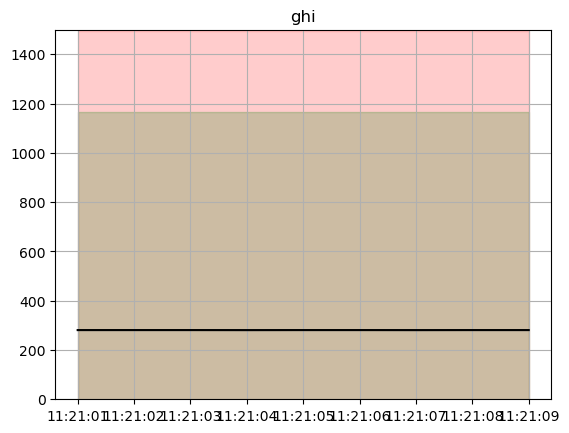

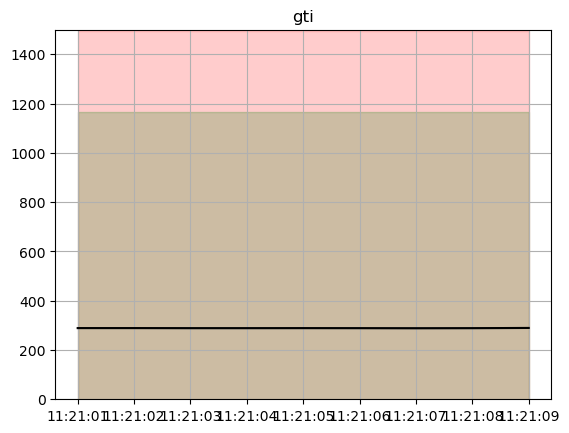

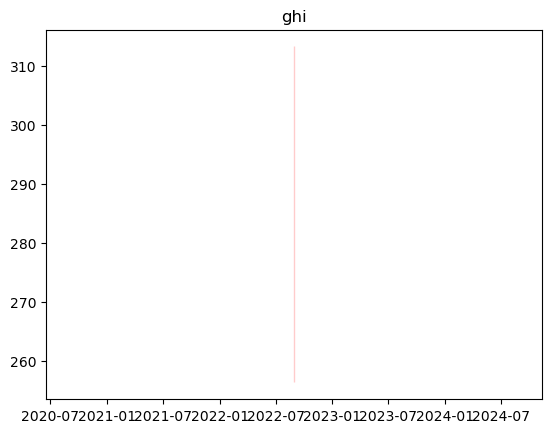

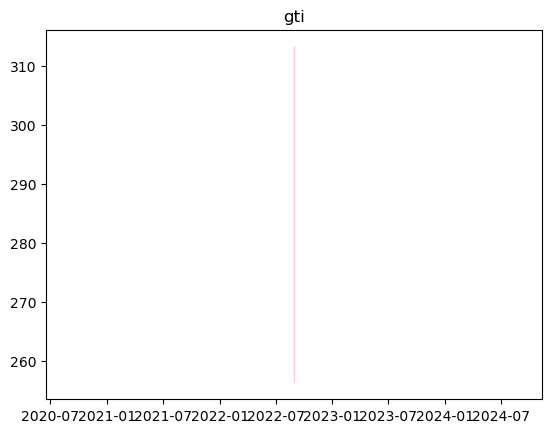

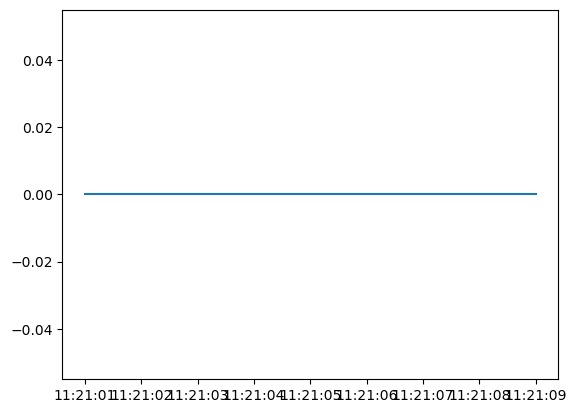

In [10]:
#|dropcode
#|dropout
dsr = ds_l1b.copy()
dsr = dsr.drop_vars([var for var in dsr if var not in config["radflux_varname"]])
for var in config["radflux_varname"]:
    is_tilted = pyrnet.utils.check_tilted(ds_l1b[var])
    values = ds_l1b[var].values.copy()
    # apply correction if possible
    if np.any(is_tilted):
        vangle = pyrnet.utils.make_iter(ds_l1b[var].attrs["vangle"])
        hangle = pyrnet.utils.make_iter(ds_l1b[var].attrs["hangle"])
        cfac = pyrnet.utils.tilt_correction_factor(
            dp = vangle,
            dy = hangle,
            szen=ds_l1b.szen.values,
            sazi=ds_l1b.sazi.values
        )
        mask = is_tilted[None,:] * np.isnan(cfac)
        ds_l1b[f"qc_flag_{var}"].values[mask] += QCCode.quality_control_failed
        apply_correction = is_tilted[None,:] * ~np.isnan(cfac)
        values[apply_correction] *= cfac[apply_correction]

    # update radflux collection dataset
    dsr[var].values = values

    # physical minimum
    mask = values < -4
    ds_l1b[f"qc_flag_{var}"].values[mask] += QCCode.below_physical
    # physical maximum
    mask = values > ((Sa * 1.5 * mu0 ** 1.2) + 100)
    ds_l1b[f"qc_flag_{var}"].values[mask] += QCCode.above_phyiscal
    # rare limit minimum
    mask = values < -2
    ds_l1b[f"qc_flag_{var}"].values[mask] += QCCode.below_rare
    # rare limit maximum
    mask = values > ((Sa * 1.2 * mu0 ** 1.2) + 50)
    ds_l1b[f"qc_flag_{var}"].values[mask] += QCCode.above_rare

    fig,ax = plt.subplots(1,1)
    ax.set_title(var)
    ax.fill_between(ds_l1b.time,np.ones(mu0.shape[0])*-4,((Sa * 1.5 * mu0 ** 1.2) + 100)[:,0],color='r',alpha=0.2)
    ax.fill_between(ds_l1b.time,np.ones(mu0.shape[0])*-2,((Sa * 1.2 * mu0 ** 1.2) + 50)[:,0],color='g',alpha=0.2)
    ax.plot(ds_l1b.time,ds_l1b[var].values,'grey')
    ax.plot(ds_l1b.time,values, 'k')
    ax.set_ylim([0,1500])
    ax.grid(True)

# compare all sensors from network, or single station
# dsr = dsr.where(np.abs(np.diff(dsr.ghi.values, axis=0, prepend=0)) < 5)
# dsr = dsr.resample(time="120min",skipna=True).mean()
window = 30*60
if dsr.time.size<window:
    window = dsr.time.size
dsrrolling = dsr.rolling(time=window)
dsr = dsrrolling.mean(skipna=True)
dsrmin = dsrrolling.min(skipna=True)
dsrmax = dsrrolling.max(skipna=True)
dsr = dsr.where(dsrmin.ghi>0.8*dsrmax.ghi)
thres_low = np.ones(ds_l1b.time.size)*0.9
thres_high = np.ones(ds_l1b.time.size)*1.1
thres_low[ds_l1b.szen.mean("station")>75] = 0.85
thres_high[ds_l1b.szen.mean("station")>75] = 1.15

all_values_tilted_flag = np.concatenate([pyrnet.utils.check_tilted(dsr[var]) for var in dsr],axis=0)
all_values = np.concatenate([dsr[var].values for var in dsr],axis=1)
all_values_mean_no_tilt = np.nanmean(all_values[:,~all_values_tilted_flag],axis=1)
all_values_mean_tilt = np.nanmean(all_values[:,all_values_tilted_flag],axis=1)

for var in config["radflux_varname"]:
    is_tilted = pyrnet.utils.check_tilted(ds_l1b[var])
    meanvalues = np.repeat(all_values_mean_no_tilt[:,None],dsr[var].shape[1],axis=1)
    meanvalues[:,is_tilted]  = all_values_mean_tilt[:,None]
    
    ratio = np.ones(dsr[var].shape)
    ratio[meanvalues>50] = dsr[var].values[meanvalues>50] / meanvalues[meanvalues>50]

    fig,ax = plt.subplots(1,1)
    ax.set_title(var)
    ax.plot(dsr.time,dsr[var].values,'grey')
    ax.fill_between(dsr.time,all_values_mean_no_tilt*0.9,all_values_mean_no_tilt*1.1,color='r',alpha=0.2)
    ax.plot(dsr.time,meanvalues,'k')
    # reindex ratio to original resolution
    dsr = dsr.assign({"ratio": (("time","station"), ratio)})
    ratio = dsr.ratio.reindex_like(ds_l1b, method='nearest').values
    dsr = dsr.drop_vars(["ratio"])
    # comparison to low
    mask = ratio < thres_low[:,None]
    ds_l1b[f"qc_flag_{var}"].values[mask] += QCCode.compare_to_low

    # comparison to high
    mask = ratio > thres_high[:,None]
    ds_l1b[f"qc_flag_{var}"].values[mask] += QCCode.compare_to_high

fig,ax = plt.subplots(1,1)
ax.plot(ds_l1b.time,ds_l1b.qc_flag_ghi)
ds_l1b

## add_qc_flag function

In [11]:
#|export
#|dropcode
def add_qc_flags(ds, vars):
    """
    Add quality flags to flux variables in the dataset.
    
    Parameters
    ----------
    ds: xr.Dataset
        Dataset with flux variables, dimensions ('time','station'). Also, solar zenith (szen) and azimuth (sazi) angles are required.
        Works for pyrnet l1b and l1b_network files.
    vars: list
        List of flux variable names in ds.

    Returns
    -------
    xr.Dataset
        The input dataset, but with additional 'qc_flag_<fluxvar>' variables.
    """
    # keep only available variables
    vars = [ var for var in vars if var in ds ]
    
    # init qc flags
    for var in vars:
        ds = init_qc_flag(ds, var) 
    
    # ancillary variables
    szen = ds.szen.values
    mu0 = np.cos(np.deg2rad(szen))
    mu0[mu0 < 0] = 0 #  exclude night
    esd = ds.esd.values
    Sa = CONSTANTS.S0 / esd**2
    
    # prepare subsample dataset, to be resampled to 30min mean for comparison checks
    dsr = ds.copy()
    dsr = dsr.drop_vars([var for var in dsr if var not in vars])
    
    # do physical and extreme limit tests
    for var in vars:
        is_tilted = pyrnet.utils.check_tilted(ds[var])
        values = ds[var].values.copy()
        
        # apply correction if possible
        if np.any(is_tilted):
            vangle = pyrnet.utils.make_iter(ds[var].attrs["vangle"])
            hangle = pyrnet.utils.make_iter(ds[var].attrs["hangle"])
            cfac = pyrnet.utils.tilt_correction_factor(
                dp = vangle,
                dy = hangle,
                szen=ds.szen.values,
                sazi=ds.sazi.values
            )
            mask = is_tilted[None,:] * np.isnan(cfac)
            ds[f"qc_flag_{var}"].values[mask] += QCCode.quality_control_failed
            apply_correction = is_tilted[None,:] * ~np.isnan(cfac)
            values[apply_correction] *= cfac[apply_correction]
        
        # update subsample dataset
        dsr[var].values = values
        
        # physical minimum
        mask = values < -4
        ds[f"qc_flag_{var}"].values[mask] += QCCode.below_physical
        # physical maximum
        mask = values > ((Sa * 1.5 * mu0 ** 1.2) + 100)
        ds[f"qc_flag_{var}"].values[mask] += QCCode.above_phyiscal
        # rare limit minimum
        mask = values < -2
        ds[f"qc_flag_{var}"].values[mask] += QCCode.below_rare
        # rare limit maximum
        mask = values > ((Sa * 1.2 * mu0 ** 1.2) + 50)
        ds[f"qc_flag_{var}"].values[mask] += QCCode.above_rare
        
        
    # compare all sensors from network, or single station
    window = 30*60
    if dsr.time.size<window:
        window = dsr.time.size
    dsrrolling = dsr.rolling(time=window)
    dsr = dsrrolling.mean(skipna=True)
    dsrmin = dsrrolling.min(skipna=True)
    dsrmax = dsrrolling.max(skipna=True)
    dsr = dsr.where(dsrmin.ghi>0.8*dsrmax.ghi)
    thres_low = np.ones(ds.time.size)*0.9
    thres_high = np.ones(ds.time.size)*1.1
    thres_low[ds.szen.mean("station")>75] = 0.85
    thres_high[ds.szen.mean("station")>75] = 1.15
    
    all_values_tilted_flag = np.concatenate([pyrnet.utils.check_tilted(dsr[var]) for var in dsr],axis=0)
    all_values = np.concatenate([dsr[var].values for var in dsr],axis=1)
    with warnings.catch_warnings():
        warnings.filterwarnings(action='ignore', message='Mean of empty slice')
        all_values_mean_no_tilt = np.nanmean(all_values[:,~all_values_tilted_flag],axis=1)
        all_values_mean_tilt = np.nanmean(all_values[:,all_values_tilted_flag],axis=1)
    
    for var in config["radflux_varname"]:
        is_tilted = pyrnet.utils.check_tilted(ds[var])
        meanvalues = np.repeat(all_values_mean_no_tilt[:,None],dsr[var].shape[1],axis=1)
        meanvalues[:,is_tilted]  = all_values_mean_tilt[:,None]
        
        ratio = np.ones(dsr[var].shape)
        ratio[meanvalues>50] = dsr[var].values[meanvalues>50] / meanvalues[meanvalues>50]
    
        fig,ax = plt.subplots(1,1)
        ax.set_title(var)
        ax.plot(dsr.time,dsr[var].values,'grey')
        ax.fill_between(dsr.time,all_values_mean_no_tilt*0.9,all_values_mean_no_tilt*1.1,color='r',alpha=0.2)
        ax.plot(dsr.time,meanvalues,'k')
        # reindex ratio to original resolution
        dsr = dsr.assign({"ratio": (("time","station"), ratio)})
        ratio = dsr.ratio.reindex_like(ds, method='nearest').values
        dsr = dsr.drop_vars(["ratio"])
        # comparison to low
        mask = ratio < thres_low[:,None]
        ds[f"qc_flag_{var}"].values[mask] += QCCode.compare_to_low
    
        # comparison to high
        mask = ratio > thres_high[:,None]
        ds[f"qc_flag_{var}"].values[mask] += QCCode.compare_to_high
    
    return ds

## Test add_qc_flag function

In [12]:
# #|dropout
fname = "../../example_data/to_l1b_output.nc"
ds = xr.load_dataset(fname)
ds 

<xarray.Dataset>
Dimensions:               (station: 1, time: 9, maintenancetime: 1)
Coordinates:
  * station               (station) float64 1.0
  * time                  (time) datetime64[ns] 2022-08-30T11:21:01 ... 2022-...
  * maintenancetime       (maintenancetime) datetime64[ns] 2023-05-08T16:09:06
Data variables: (12/20)
    ghi                   (time, station) float32 280.9 280.9 ... 280.9 280.9
    gti                   (time, station) float32 289.0 289.0 ... 288.6 289.5
    ta                    (time, station) float32 294.8 294.7 ... 294.7 294.8
    rh                    (time, station) float32 0.6253 0.6248 ... 0.628 0.629
    battery_voltage       (time, station) float32 6.443 6.445 ... 6.449 6.465
    gti_min               (time, station) float32 288.6 288.6 ... 288.6 288.6
    ...                    ...
    maintenance_flag_gti  (maintenancetime, station) float32 7.0
    szen                  (time, station) float32 42.51 42.51 ... 42.51 42.51
    sazi                  (time, station) float32 182.9 182.9 ... 182.9 182.9
    esd                   (station) float64 1.01
    qc_flag_ghi           (time, station) float32 0.0 0.0 0.0 ... 0.0 0.0 0.0
    qc_flag_gti           (time, station) float32 0.0 0.0 0.0 ... 0.0 0.0 0.0
Attributes: (12/31)
    Conventions:               CF-1.10, ACDD-1.3
    title:                     TROPOS pyranometer network (PyrNet) observatio...
    history:                   2024-05-31T13:47:06: Generated level l1a  by p...
    institution:               Leibniz Institute for Tropospheric Research (T...
    source:                    TROPOS pyranometer network (PyrNet)
    references:                https://doi.org/10.5194/amt-9-1153-2016
    ...                        ...
    geospatial_lon_max:        11.885252
    geospatial_lon_units:      degE
    time_coverage_start:       2022-08-30T11:21:01
    time_coverage_end:         2022-08-30T11:21:09
    time_coverage_duration:    P0DT0H0M8S
    time_coverage_resolution:  P0DT0H0M1S

In [13]:
%load_ext memory_profiler
from pyrnet.qcrad import add_qc_flags as test_add_qc_flags


In [14]:
# %%mprun -f test_add_qc_flags
# _ = test_add_qc_flags(ds, ["ghi", "gti"])

NameError: name 'ds_l1b' is not defined

In [ ]:
#|dropout
ds = add_qc_flags(ds, ["ghi", "gti"])
ds

In [ ]:
#|hide
# Export module
# Requires *nbdev* to export and update the *../lib/logger.py* module
import nbdev.export
import nbformat as nbf
name = "qcrad"

# Export python module
nbdev.export.nb_export( f"{name}.ipynb" ,f"../../src/pyrnet")

# Export to docs
ntbk = nbf.read(f"{name}.ipynb", nbf.NO_CONVERT)

text_search_dict = {
    "#|hide": "remove-cell",  # Remove the whole cell
    "#|dropcode": "hide-input",  # Hide the input w/ a button to show
    "#|dropout": "hide-output"  # Hide the output w/ a button to show
}
for cell in ntbk.cells:
    cell_tags = cell.get('metadata', {}).get('tags', [])
    for key, val in text_search_dict.items():
            if key in cell['source']:
                if val not in cell_tags:
                    cell_tags.append(val)
    if len(cell_tags) > 0:
        cell['metadata']['tags'] = cell_tags
    nbf.write(ntbk, f"../../docs/source/nbs/{name}.ipynb")